In [1]:
import random
import string
import re

import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
seed = 69420
np.random.seed(seed)
random.seed(seed)

In [3]:
# Classification labels
labels = ["generated", "human"]

# English stopwords
nltk.download("stopwords")
eng_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/riga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Import main dataset
df = pd.read_csv("../AUTEXTIFICATION/subtask_1/train.tsv", sep="\t")
df = df.drop("id", axis=1)

# Import additional dataset as test (only generated)
dff = pd.read_csv("../AUTEXTIFICATION/subtask_2/train.tsv", sep="\t")
dff = dff.drop("id", axis=1)
dff["label"] = dff["label"].apply(lambda x: "generated")

df

,text,label
0,you need to stop the engine and wait until it ...,generated
1,The Commission shall publish the report; an in...,generated
2,"I have not been tweeting a lot lately, but I d...",generated
3,I pass my exam and really thankgod for that bu...,human
4,The template will have 3 parts: a mustache sha...,human
...,...,...
33840,"@PierreJoye i have a server already, thanks fo...",human
33841,10. Article 13 of Council Directive 80/777/EEC...,human
33842,"Crying because I have to cry for you?. No. No,...",generated
33843,"However, it will continue to offer customers a...",generated


In [5]:
def preprocess(df, field):
    # Convert all text to lowercase
    df[field] = df[field].apply(lambda x: x.lower())

    # Remove punctuation and reset multiple spaces to one
    punct_regex = re.compile("[" + string.punctuation + "\’'" + "]")
    whitespace_regex = re.compile(" ( )+")
    df[field] = df[field].apply(
        lambda x: whitespace_regex.sub(" ", punct_regex.sub(" ", x))
    )

    # Create dataframe without stopwords
    df_stop = df.copy()
    df_stop[field] = df[field].apply(
        lambda x: " ".join([w for w in x.split() if w not in eng_stopwords])
    )
    return df, df_stop

In [6]:
def evaluate(y_true, y_pred):
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    cm_display.plot()
    plt.show()

In [7]:
df, df_stop = preprocess(df, "text")
dff, dff_stop = preprocess(dff, "text")

In [8]:
# train, test = train_test_split(df, test_size=0.2)
train, test = train_test_split(df_stop, test_size=0.2)

x_train, y_train = train["text"], train["label"]
x_test, y_test = train["text"], train["label"]

x_add_test, y_add_test = dff_stop["text"], dff_stop["label"]

In [9]:
# Vocabulary information of main dataset
vocab = " ".join(df["text"]).split(sep=" ")
nonstop_vocab = " ".join(df_stop["text"]).split(sep=" ")

vocab_count = nltk.Counter(nonstop_vocab)
vocab_count.most_common(len(vocab_count))

[('shall', 16191),
 ('article', 14347),
 ('regulation', 13055),
 ('1', 9998),
 ('2', 9340),
 ('member', 6219),
 ('states', 5610),
 ('may', 5297),
 ('3', 5000),
 ('done', 4485),
 ('force', 4418),
 ('european', 4070),
 ('use', 4045),
 ('day', 3890),
 ('enter', 3869),
 ('make', 3846),
 ('also', 3837),
 ('decision', 3652),
 ('brussels', 3512),
 ('annex', 3424),
 ('following', 3363),
 ('4', 3340),
 ('one', 3292),
 ('applicable', 3181),
 ('get', 3169),
 ('time', 3053),
 ('like', 3049),
 ('commission', 3007),
 ('directly', 2809),
 ('binding', 2797),
 ('need', 2748),
 ('official', 2669),
 ('entirety', 2633),
 ('ec', 2566),
 ('want', 2551),
 ('journal', 2475),
 ('5', 2444),
 ('publication', 2400),
 ('apply', 2333),
 ('take', 2297),
 ('sure', 2199),
 ('help', 2128),
 ('im', 2018),
 ('good', 1995),
 ('new', 1924),
 ('products', 1911),
 ('community', 1883),
 ('directive', 1862),
 ('eec', 1850),
 ('way', 1849),
 ('work', 1801),
 ('know', 1788),
 ('first', 1764),
 ('see', 1749),
 ('water', 1730),
 (

In [10]:
# min_df higher than 1 seems to perform worse
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer(sublinear_tf=True)

              precision    recall  f1-score   support

   generated       0.81      0.87      0.84     13497
       human       0.86      0.79      0.83     13579

    accuracy                           0.83     27076
   macro avg       0.83      0.83      0.83     27076
weighted avg       0.83      0.83      0.83     27076



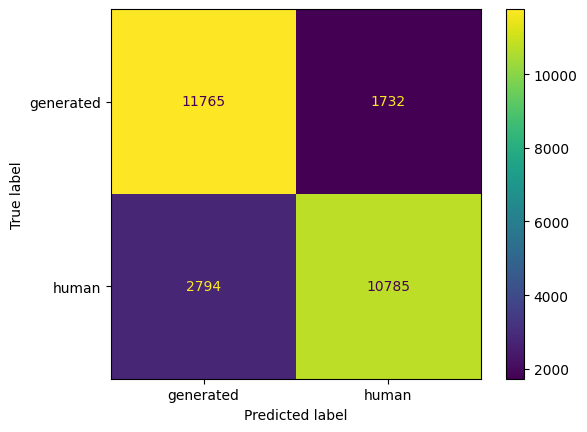

In [11]:
# Naive Bayes

x_train_counts = vectorizer.fit_transform(x_train)
x_test_counts = vectorizer.transform(x_test)

nb = MultinomialNB()
nb.fit(x_train_counts, y_train)

y_pred = nb.predict(x_test_counts)

evaluate(y_test, y_pred)

In [12]:
# min_df higher than 1 seems to perform worse
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer(sublinear_tf=True)

              precision    recall  f1-score   support

   generated       0.95      0.95      0.95     13497
       human       0.95      0.95      0.95     13579

    accuracy                           0.95     27076
   macro avg       0.95      0.95      0.95     27076
weighted avg       0.95      0.95      0.95     27076



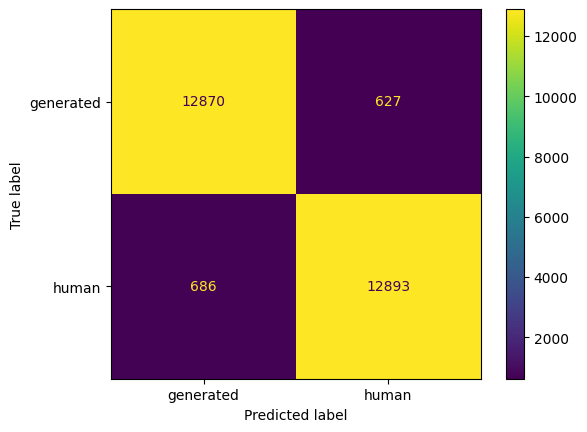

In [13]:
# Logistic Regression

x_train_counts = vectorizer.fit_transform(x_train)
x_test_counts = vectorizer.transform(x_test)

lr = LogisticRegression(max_iter=1000)

lr.fit(x_train_counts, y_train)

y_pred = lr.predict(x_test_counts)

evaluate(y_test, y_pred)